## HVI Tutorial (Part 3: Species)

Elchin Jafarov 
8/2018

## 3. Species
Here we show how we calculate scores for each specie in the framework

In [1]:
import numpy as np
#import hsiscore_class as HSI
import hsiscore_class as HSI
import LLM_model_class as llm
#import LLM_model_cpy as llm
import hsi_plot_utils as hsi_plt
import matplotlib.pyplot as plt
import time
%matplotlib inline
hsi=HSI.hsi_score()

Here we read llp and hw distribution from previous file instantiate(1), then run the model for 200 years, and plot llp and hw tree numbers for a the correspoding p.tree_mature_age. 

no. of starting HW trees 68
--- 191.462876081 seconds ---


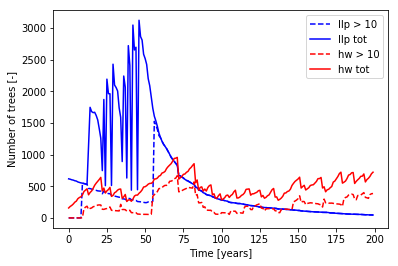

In [2]:
p = llm.LLM()     # assign p to the llm class
#NOTE: p.instantiate(1) assumes that runs correspoding input files do exist if not then run
#p.instantiate(0)  # 1: reads input data from file, 0: generate inputs internally
#p.verbose=0
#p.run(200)
#p.save_pickle()

p.instantiate(1)  # 1: reads input data from file, 0: generate inputs internally
p.verbose=0       # 0: do not print out scores, 1: print scores on the screen
p.tree_mature_age=10
p.readfireprobfromfile=0
p.readmastprobfromfile=0

start_time = time.time()
p.run(200)
print("--- %s seconds ---" % (time.time() - start_time))

hsi_plt.plot_tree_count(p)

##  Sherman’s fox squirrel (SQ)

To calculte score for the Sherman’s fox squirrel I added a function called 'prob_of_use_sq'. This function utilizes the 'subset_matrix' and 'gscore' function from hvi_score (see Part 1). First it calcultes the ratio of mature pine to hardwood. Then compares it to the graph from  [Fig 2. by Perkins  at al., (2008)](https://doi.org/10.1016/j.foreco.2007.11.020). Here I adjusted the gscore function to match the estimated probability of use graph. Note, that 'mature_hw_age' constraint can be passsed to the function. This was done in order to control division by zero case, if fire kills all the hardwood trees then this would lead to division by zero. Under this scenario function will generate an error, which will popout as a warninng that would not stop the current run. 

0.0334616405127
Estimated probability of use, p( 15.64 )= 0.24


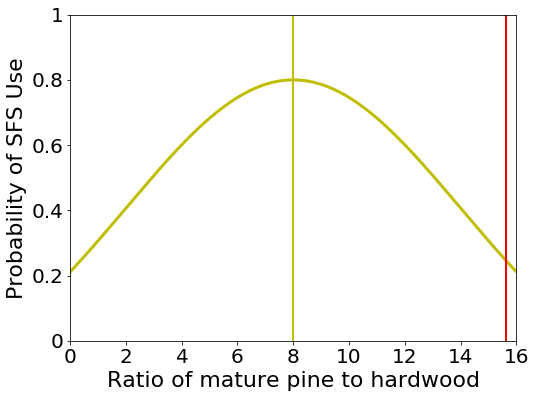

In [3]:
# Illustration of the probability of tree use for fox squirel calculated according to the Fig.2 (Perkins et al., 2008)

x=np.linspace(-50,50,1000)
hsi.x0=x
hsi.sigma = 6
dist=hsi.norm_gaussian()
hsi.x0=15.64
print hsi.norm_gaussian()

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(x, dist-0.2, linewidth=3, color='y')
plt.plot(np.zeros(10), np.linspace(0,1,10), linewidth=2, color='y')
x0=15.64#10.41
plt.plot((x0-8)*np.ones(10), np.linspace(0,1,10), linewidth=2, color='r')
plt.xlabel('Ratio of mature pine to hardwood',fontsize=22)
plt.ylabel('Probability of SFS Use',fontsize=22)
plt.xlim(-8,8);
plt.ylim(0,1)
xnames = range(0,18,2)
ax.set_xticklabels(xnames, fontsize=20)

ynames = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticklabels(ynames, fontsize=20)

#NOTE: here hsi.x0 is assigned inside of the gscore function
hsi.number = 15.64
hsi.bench = 8
hsi.smooth = 0 
print 'Estimated probability of use, p(',x0,')=',round(hsi.gscore()-.2,2)

Let's plot the ration of LLP to HW for the entire domain (default 25x25=625, 10 trees per each cell)

HW trees > 10: [357.0, 361.0, 380.0, 400.0, 324.0, 318.0, 309.0, 368.0, 382.0]
HW total: 722.0
LLP trees > 10: [56.0, 55.0, 53.0, 52.0, 50.0, 50.0, 48.0, 48.0, 47.0]
LLP total: 46.0
hw/llp ratio: 0.12


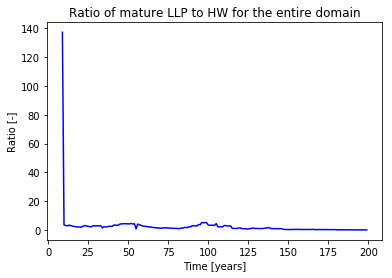

In [4]:
hsi_plt.plot_llp2hw_ratio(p)

Two lines below validate 'prob_of_use_sq' function from hsiscore class.

In [5]:
lp_age=p.old_age
lp_count=p.old_LPcount
hw_age=p.old_ageHW
hw_count=p.old_HWcount
mature_tree_age=30
nsize=5
msize=5
[n,m]=np.shape(lp_age)

# check if matrix can be evenly divided
if np.mod(int(m),msize):
    raise ValueError('matrix horizonal dim:',m,' cannot be divided by',msize)
if np.mod(int(n),nsize):
    raise ValueError('ERROR: matrix vertical dim:',n,' cannot be divided by',nsize)  

# divide matrix to equal subsets
v=range(0,int(n),nsize)
#h=range(0,m-msize+1) # if steping size is 1
h=range(0,int(m),msize)

# loop through subsets and calculate the #lp/#hw ratio
ratio=[]
for i in v:
    for j in h:
        # subset each matrix
        sub_pl_age=hsi.subset_matrix(lp_age, i, j)
        sub_lp_count=hsi.subset_matrix(lp_count, i, j)
        sub_hw_age=hsi.subset_matrix(hw_age, i, j)
        sub_hw_count=hsi.subset_matrix(hw_count, i, j)
        # find indexes of the mature LP and HW trees
        idl=np.nonzero(sub_pl_age > mature_tree_age) 
        idh=np.nonzero(sub_hw_age > mature_tree_age)
        # sum number of trees per cell
        num_of_lp=np.sum(sub_lp_count[idl[0][:],idl[1][:]])
        num_of_hw=np.sum(sub_hw_count[idh[0][:],idh[1][:]])
        # check division by zero 
        if num_of_hw!=0:
            ratio.append(num_of_lp/num_of_hw)
            #print num_of_lp,num_of_hw,num_of_lp/num_of_hw
print ratio 
if ratio==[]:
    print 'WARNING: in prob_of_use_sq, no hardwood trees older than ',mature_tree_age,\
            'years.'
    if idl!=[]: 
        prob_of_use=0.2
    else:
        print 'ERROR: in prob_of_use_sq, all mature trees killed by fire'
        sys.exit(1)
else:
    # Probability of use curve calculated according to the Fig.2 (Perkins et al., 2008)
    x0=np.mean(np.asarray(ratio))
    # Here we do not need x0, gscore will calculate it from number and bench
    hsi.number = x0
    hsi.sigma = 6
    hsi.bench =8
    hsi.smooth = 0 
    prob_of_use=hsi.gscore()-.2
    
    if prob_of_use<0:
        prob_of_use=0
print 'Estimated probability of use, p(',round(x0,2),')=',round(prob_of_use,2)

[0.66666666666666663, 1.0, 0.0, 1.5, 0.5, 0.44444444444444442, 1.0, 1.0, 0.80000000000000004, 3.0, 0.25, 0.23076923076923078, 0.14285714285714285, 0.5, 0.66666666666666663, 0.25, 2.0, 0.5, 0.75, 0.40000000000000002, 0.0, 0.0, 1.0]
Estimated probability of use, p( 0.72 )= 0.28


In [6]:
print 'prob_of_use_sq for 5x5 subset count'
hsi.nsize = 5
hsi.msize = 5
sq_scr = hsi.prob_of_use_sq(p.old_age, p.old_LPcount, p.old_ageHW, p.old_HWcount,mature_tree_age)
print 'Estimated probability of use:',round(sq_scr,2)
#Check if probabilities match
assert prob_of_use == sq_scr

prob_of_use_sq for 5x5 subset count
Estimated probability of use: 0.28


## Gopher Tortoise (GT)

To calculate score for the GT I used burrow status = 'Abandoned' metric  [Fig.4 by Catano et al., (2014) ](http://www.bioone.org/doi/abs/10.2744/CCB-1101.1). Since graph on Figure 4 looks more like a straight line going from 30% to 75% Abandoned probability. I fliped the 'Abandoned' to 'Use' for consistency and simplicity. 'prob_of_use_gt' function is utilizing 'gscore' function and operates only with positive range of number since canopy cover cannot be negative.GT depends on the density of the canopy cover, where midstory defines the shortest tree after which consider the midstory cover. Changing that will affect the GT score.    

Estimated probability of use( 0.8 )= 0.37


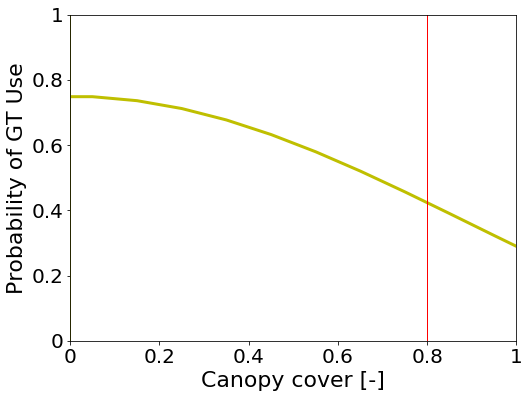

In [9]:
# Benchmarking mean probability of burrow status = 'Abandoned' for GT calculated according to the Fig.4 (Catano et al., 2014)
# In this case, I reverted the 'Abandoned' probability to probability of use 

x=np.linspace(-50,50,1000)
hsi.x0=x
hsi.sigma=0.9 # standard deviation
dist=hsi.norm_gaussian()

hsi.number = 0.8
hsi.sigma = 0.9
hsi.bench = 0
hsi.smooth = 0 
print 'Estimated probability of use(',hsi.number,')=',round(hsi.gscore()-.3,2)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(x, dist-0.25, linewidth=3, color='y')
plt.plot(np.zeros(10), np.linspace(0,1,10), linewidth=1, color='y')
plt.plot(hsi.number*np.ones(10), np.linspace(0,1,10), linewidth=1, color='r')
plt.xlabel('Canopy cover [-]',fontsize=22)
plt.ylabel('Probability of GT Use',fontsize=22)
plt.xlim(0,1);
plt.ylim(0,1)

ynames = [0,0.2,0.4,0.6,0.8,1];
ax.set_xticklabels(ynames, fontsize=20);
ax.set_yticklabels(ynames, fontsize=20);

In [15]:
abs(abs(0.5-np.random.rand(10))-0.1)

array([ 0.07211354,  0.36766656,  0.36870092,  0.11289341,  0.06230972,
        0.02463572,  0.02988246,  0.25028885,  0.02689374,  0.33320679])

Note, that according to the paper (Figure 2) we choose the radius eqaul to 15m which reperesents 3x3 grid cells, i.e. it is not advisable to change the resolution (nsize and msize) unless the resoution of a cell changes. 

Below I compare probability of use calculted by counting trees in the area and by calculating the basal area. Because in both cases we end up with small percent_canopy number leading to high probability. 

In [10]:
#def prob_of_use_gt(lp_age, lp_count,hw_age, hw_count, mature_hw_age,nsize=3, msize=3):

lp_age=p.old_ht
lp_count=p.old_LPcount
hw_age=p.old_htHW
hw_count=p.old_HWcount
nsize=3
msize=3

# divides matrix x(n,m) to subsets of matrices of size (nsize, msize)
# only works when matrix can be equally divided to subsets
# nsize : vertical size of the window
# msize : horizonal size of the window

# get the dimensions of the matrix
[n,m]=np.shape(lp_age)
hsi.nsize=3
hsi.msize=3

ntot=hsi.nsize*hsi.msize

# divide matrix to equal subsets
v=range(0,int(n),hsi.nsize)
#h=range(0,m-msize+1) # if steping size is 1
h=range(0,int(m),hsi.msize)

# loop through subsets and calculate the #lp/#hw ratio
percent_canopy=[]
prob_of_use=[] # new version
for i in v[:-1]:
    for j in h[:-1]:
        # subset each matrix
        sub_pl_height=hsi.subset_matrix(lp_age, i, j)
        sub_lp_count=hsi.subset_matrix(lp_count, i, j)
        sub_hw_height=hsi.subset_matrix(hw_age, i, j)
        sub_hw_count=hsi.subset_matrix(hw_count, i, j)
        # find indexes of the mature LP and HW trees
        # overstory
        idl=np.nonzero(sub_pl_height > 20)
        idh=np.nonzero(sub_hw_height > 15)
        # sum number of trees per cell
        num_of_lp=np.sum(sub_lp_count[idl[0][:],idl[1][:]])
        num_of_hw=np.sum(sub_hw_count[idh[0][:],idh[1][:]])
        idl=np.nonzero(sub_pl_height < 2)
        idh=np.nonzero(sub_hw_height < 2)
        # here we count non-empty spaces by in 3x3 area
        # the percent of ocupied cells divided by 9 cells to get the canopy percent area 
        a=np.zeros(ntot)
        a[sub_pl_height.flatten()>1]=1
        b=np.zeros(ntot)
        b[sub_hw_height.flatten()>1]=1
        c=a+b
        c[c==2]=1
        #print c
        percent_canopy.append(np.sum(c)/ntot)
        #print np.sum((c*nrand))

# Mean probability burrow status = 'Abandoned' according to the Fig.4 (Catano et al., 2014)
# Here flipped that formula to the probability of use for consistency with SFS

hsi.bench = 0
hsi.smooth = 0
hsi.sigma = 0.9
for i in percent_canopy:
    hsi.number = float(i)
    prob_of_use.append(hsi.gscore ()-.3)
    #print 'per_can:',round(i,3)
    #print 'prob of use:',self.gscore()-.3

prob=np.asarray(prob_of_use)
prob[prob<0]=0
#Check if probabilities match
print 'GT probability of use:',np.mean(prob)

GT probability of use: 0.563950410534


In [13]:
#NOTE: for GT msize and nsize are hardcoded and equal to 3
gt_scr = hsi.prob_of_use_gt_new(p.old_ht, p.old_LPcount, p.old_htHW, p.old_HWcount)
print 'Estimated probability of use:',gt_scr
assert np.mean(prob) == gt_scr

Estimated probability of use: 0.563950410534


## Red Cockaded Woodpecker (RCW)
Note that score for the RCW combined from multiple scores. Below we plot the distribution of all of scores contribution to the RCW total score. Here we use benchmarking table the tight up with resolution. If we change the subset sampling resolution if is going to all RCW scores. The HSI for the RCW was inspired by this
[website](http://www.lmvjv.org/hsi_model/species/rcwo/s_rcwo.aspx#anchor_naturalhistory).

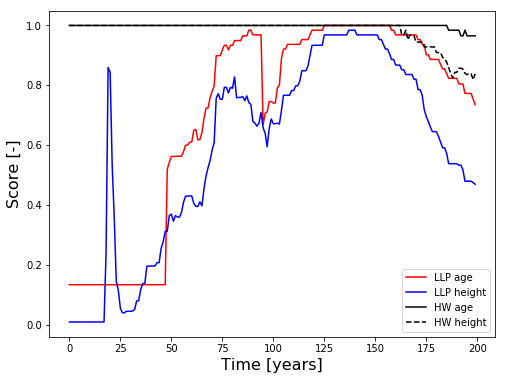

In [14]:
hsi_plt.plot_rcw_scores(p)

## All three species score 

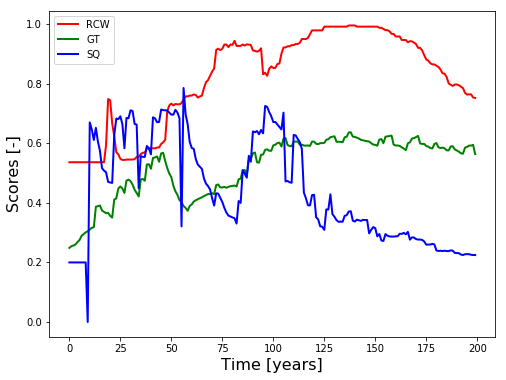

In [15]:
hsi_plt.plot_species_scores(p)